## Setup

In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.7.0
• GPU Device Found.


## Read the processed data into the training dataset and validation dataset

In [3]:
TRAINING_DIR = "train_dir/"
VALIDATION_DIR = "validation_dir/"

In [4]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale= 1./255.,
                                        rotation_range=180,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,             
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode="categorical",
                                                        target_size=(229, 229))

    
    validation_datagen = ImageDataGenerator(rescale=1./255.)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  class_mode="categorical",
                                                                  target_size=(229, 229))
    
    return train_generator, validation_generator

In [5]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 11203 images belonging to 40 classes.
Found 2801 images belonging to 40 classes.


In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

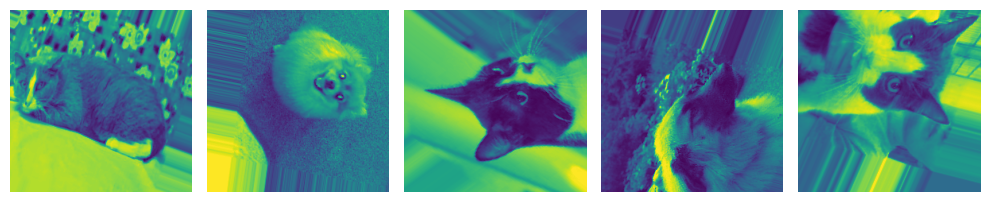

In [7]:
sample_training_images, _= next(train_generator)
plotImages(sample_training_images[:5])

## Creating a Callback class

In [8]:
class cb(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90):
            print("\nAccuracy has reached above 90%, training stops")
            self.model.stop_training = True # training will stop when accuracy and val_accuracy have reached >= 90%

callbacks = cb()

## Define, compile and Train the model

In [13]:
def create_model():
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv2D(32,(3,3),activation="relu", input_shape=(229, 229, 3)),
        tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(256, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2048,activation="relu"),
        tf.keras.layers.Dense(512,activation="relu"),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dense(40,activation="softmax")
    ])

  
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy']) 
    return model

In [14]:
model = create_model()

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 227, 227, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 225, 225, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 110, 110, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 53, 53, 128)      

In [16]:
# Train the model
history = model.fit(train_generator,
                    epochs=300,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks]
                   )

Epoch 1/300
351/351 [==============================] - 128s 363ms/step - loss: 3.6364 - accuracy: 0.0350 - val_loss: 3.7053 - val_accuracy: 0.0403
Epoch 2/300
351/351 [==============================] - 124s 352ms/step - loss: 3.4933 - accuracy: 0.0565 - val_loss: 3.5136 - val_accuracy: 0.0657
Epoch 3/300
351/351 [==============================] - 120s 342ms/step - loss: 3.3378 - accuracy: 0.0866 - val_loss: 3.5417 - val_accuracy: 0.0710
Epoch 4/300
351/351 [==============================] - 119s 339ms/step - loss: 3.2439 - accuracy: 0.0979 - val_loss: 3.6715 - val_accuracy: 0.0885
Epoch 5/300
351/351 [==============================] - 120s 343ms/step - loss: 3.1632 - accuracy: 0.1225 - val_loss: 3.3586 - val_accuracy: 0.0989
Epoch 6/300
351/351 [==============================] - 122s 348ms/step - loss: 3.0778 - accuracy: 0.1340 - val_loss: 3.5364 - val_accuracy: 0.0921
Epoch 7/300
351/351 [==============================] - 122s 346ms/step - loss: 3.0155 - accuracy: 0.1458 - val_loss: 3

351/351 [==============================] - 121s 343ms/step - loss: 0.8860 - accuracy: 0.7155 - val_loss: 3.6691 - val_accuracy: 0.3131
Epoch 112/300
351/351 [==============================] - 121s 343ms/step - loss: 0.8923 - accuracy: 0.7112 - val_loss: 3.9348 - val_accuracy: 0.3035
Epoch 113/300
351/351 [==============================] - 121s 345ms/step - loss: 0.8629 - accuracy: 0.7219 - val_loss: 3.8319 - val_accuracy: 0.3195
Epoch 114/300
351/351 [==============================] - 120s 341ms/step - loss: 0.8476 - accuracy: 0.7281 - val_loss: 4.0358 - val_accuracy: 0.2899
Epoch 115/300
351/351 [==============================] - 119s 339ms/step - loss: 0.8248 - accuracy: 0.7357 - val_loss: 3.5945 - val_accuracy: 0.3313
Epoch 116/300
351/351 [==============================] - 118s 336ms/step - loss: 0.8025 - accuracy: 0.7432 - val_loss: 3.5835 - val_accuracy: 0.3327
Epoch 117/300
351/351 [==============================] - 117s 334ms/step - loss: 0.8179 - accuracy: 0.7361 - val_loss: 3

351/351 [==============================] - 118s 336ms/step - loss: 0.4008 - accuracy: 0.8657 - val_loss: 4.7760 - val_accuracy: 0.3320
Epoch 167/300
351/351 [==============================] - 117s 334ms/step - loss: 0.3918 - accuracy: 0.8736 - val_loss: 5.1039 - val_accuracy: 0.3224
Epoch 168/300
351/351 [==============================] - 119s 339ms/step - loss: 0.3694 - accuracy: 0.8796 - val_loss: 5.1053 - val_accuracy: 0.3117
Epoch 169/300
351/351 [==============================] - 118s 336ms/step - loss: 0.4005 - accuracy: 0.8712 - val_loss: 5.9514 - val_accuracy: 0.2949
Epoch 170/300
351/351 [==============================] - 120s 342ms/step - loss: 0.3921 - accuracy: 0.8725 - val_loss: 4.7574 - val_accuracy: 0.3288
Epoch 171/300
351/351 [==============================] - 118s 337ms/step - loss: 0.3878 - accuracy: 0.8743 - val_loss: 5.2663 - val_accuracy: 0.3163
Epoch 172/300
351/351 [==============================] - 117s 333ms/step - loss: 0.3658 - accuracy: 0.8805 - val_loss: 5

351/351 [==============================] - 120s 343ms/step - loss: 0.2335 - accuracy: 0.9257 - val_loss: 5.9783 - val_accuracy: 0.3070
Epoch 222/300
351/351 [==============================] - 121s 343ms/step - loss: 0.2358 - accuracy: 0.9232 - val_loss: 5.6660 - val_accuracy: 0.3195
Epoch 223/300
351/351 [==============================] - 119s 340ms/step - loss: 0.2394 - accuracy: 0.9207 - val_loss: 6.2722 - val_accuracy: 0.3081
Epoch 224/300
351/351 [==============================] - 122s 349ms/step - loss: 0.2274 - accuracy: 0.9260 - val_loss: 5.3505 - val_accuracy: 0.3352
Epoch 225/300
351/351 [==============================] - 126s 358ms/step - loss: 0.2197 - accuracy: 0.9296 - val_loss: 5.8518 - val_accuracy: 0.3242
Epoch 226/300
351/351 [==============================] - 131s 372ms/step - loss: 0.2281 - accuracy: 0.9250 - val_loss: 5.3895 - val_accuracy: 0.3367
Epoch 227/300
351/351 [==============================] - 126s 360ms/step - loss: 0.2228 - accuracy: 0.9291 - val_loss: 5

351/351 [==============================] - 122s 347ms/step - loss: 0.1592 - accuracy: 0.9496 - val_loss: 6.5238 - val_accuracy: 0.3224
Epoch 277/300
351/351 [==============================] - 120s 342ms/step - loss: 0.1976 - accuracy: 0.9376 - val_loss: 5.8082 - val_accuracy: 0.3195
Epoch 278/300
351/351 [==============================] - 118s 335ms/step - loss: 0.1524 - accuracy: 0.9519 - val_loss: 6.3305 - val_accuracy: 0.3224
Epoch 279/300
351/351 [==============================] - 120s 341ms/step - loss: 0.1584 - accuracy: 0.9489 - val_loss: 6.1193 - val_accuracy: 0.3281
Epoch 280/300
351/351 [==============================] - 123s 349ms/step - loss: 0.1690 - accuracy: 0.9473 - val_loss: 6.1912 - val_accuracy: 0.3295
Epoch 281/300
351/351 [==============================] - 122s 347ms/step - loss: 0.1665 - accuracy: 0.9431 - val_loss: 6.6871 - val_accuracy: 0.3152
Epoch 282/300
351/351 [==============================] - 121s 346ms/step - loss: 0.1622 - accuracy: 0.9471 - val_loss: 6

### Training History

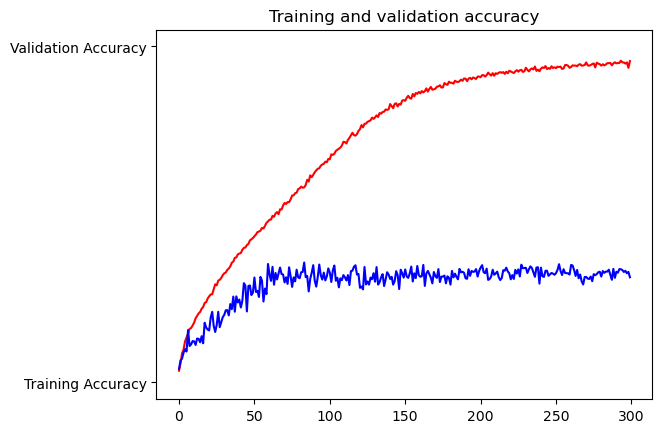

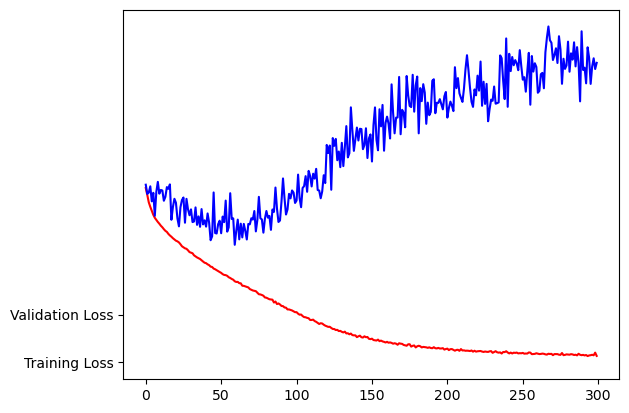

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

## save model format Keras HDF5

In [40]:
model.save('model_v1.h5')

## Save model Exporting to TFLite

In [41]:
export_dir = 'saved_model/modelku_1'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/modelku_1\assets


In [42]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [43]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)# YOUR CODE HERE

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [44]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

14834240